In [1]:
# Operating System
import os

import pickle
import json

#Pandas and Numpy
import pandas as pd
import numpy as np

#ramdom generator
import random

# from sklearn.model_selection import train_test_split

# from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
# from sklearn.base import TransformerMixin, BaseEstimator

# import category_encoders as ce
# from sklearn.preprocessing import KBinsDiscretizer, Binarizer

# from sklearn.ensemble import RandomForestClassifier
# from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, classification_report
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import confusion_matrix

# # Custom transformers
# from custom_transformers.transformer import Selector, TextSelector, NumberSelector, BoolSelector, TextCleanerTransformer

# #CURL requests
# import requests 

#Plots
import matplotlib.pyplot as plt
%matplotlib inline

# # Statistics
# from scipy.stats import binom_test

# Strings
import re


# Load data production

In [2]:
file_path = os.path.join('heroku', 'heroku_db', 'heroku_complete_db.csv')

df_results = pd.read_csv(file_path,
                         sep=";",
                         # nrows = 100, 
                         header=0,
                         warn_bad_lines=True)



In [3]:
df_results.head()

,id,observation_id,observation,proba,true_class
0,3,0,"{""id"": 0, ""observation"": {""Department Name"": ""...",0.456029,0.0
1,4,1,"{""id"": 1, ""observation"": {""Department Name"": ""...",0.456029,0.0
2,5,2,"{""id"": 2, ""observation"": {""Department Name"": ""...",0.490537,1.0
3,6,3,"{""id"": 3, ""observation"": {""Department Name"": ""...",0.490537,1.0
4,7,4,"{""id"": 4, ""observation"": {""Department Name"": ""...",0.000000,0.0


In [4]:
observations_decoupled = df_results['observation'].apply(json.loads).apply(pd.Series)

In [5]:
observations_decoupled.head()

,id,observation
0,0,"{'Department Name': 'Vernon', 'InterventionDat..."
1,1,"{'Department Name': 'Vernon', 'InterventionDat..."
2,2,"{'Department Name': 'Milford', 'InterventionDa..."
3,3,"{'Department Name': 'Milford', 'InterventionDa..."
4,4,"{'Department Name': 'Norwalk', 'InterventionDa..."


In [6]:
df_obs = pd.DataFrame(list(observations_decoupled.observation), index=observations_decoupled.id)

In [7]:
df_obs.head()

,Department Name,InterventionDateTime,InterventionLocationName,InterventionReasonCode,ReportingOfficerIdentificationID,ResidentIndicator,SearchAuthorizationCode,StatuteReason,SubjectAge,SubjectEthnicityCode,SubjectRaceCode,SubjectSexCode,TownResidentIndicator
id,,,,,,,,,,,,,
0,Vernon,05/16/2018 02:39:00 AM,VERNON,V,625,False,C,Registration,40.0,N,B,M,False
1,Vernon,05/16/2018 02:39:00 AM,VERNON,V,625,False,C,Registration,40.0,N,B,M,False
2,Milford,05/16/2018 04:08:00 AM,MILFORD,E,473,True,I,Other,49.0,N,B,F,False
3,Milford,05/16/2018 04:08:00 AM,MILFORD,E,473,True,I,Other,49.0,N,B,F,False
4,Norwalk,05/16/2018 09:38:00 AM,NORWALK,V,100000335,True,I,Defective Lights,35.0,N,W,M,True


In [8]:
df_obs['proba'] = df_results['proba']

In [9]:
df_obs['true_class'] = df_results['true_class']

In [10]:
df_obs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10002 entries, 0 to 900003
Data columns (total 15 columns):
Department Name                     10002 non-null object
InterventionDateTime                10002 non-null object
InterventionLocationName            10002 non-null object
InterventionReasonCode              10002 non-null object
ReportingOfficerIdentificationID    10002 non-null object
ResidentIndicator                   10002 non-null bool
SearchAuthorizationCode             10002 non-null object
StatuteReason                       10002 non-null object
SubjectAge                          10002 non-null float64
SubjectEthnicityCode                10002 non-null object
SubjectRaceCode                     10002 non-null object
SubjectSexCode                      10002 non-null object
TownResidentIndicator               10002 non-null bool
proba                               10000 non-null float64
true_class                          5000 non-null float64
dtypes: bool(2), float

In [11]:
df_obs_known = df_obs.dropna()

# Load data training

In [12]:
file_path = os.path.join('data', 'train.csv')

# Option for reading a sample of the file
# sample 20% of the rows
p = 1

random.seed(178) # this is to get always the same sample. can be removed if we want the sample to change
try:
    df_original = pd.read_csv(file_path, 
                             skiprows = lambda row_num: random.random() > p and row_num > 0,                              
                             header=0,
                             warn_bad_lines=True)
except:
    print('Ooops!!! We got an error!')
else:
    # Drop observations correspoding to stops that didn't lead to a search
    df_train = df_original[df_original.VehicleSearchedIndicator==True].reset_index(drop=True).drop(columns='VehicleSearchedIndicator')
    del df_original


In [13]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76743 entries, 0 to 76742
Data columns (total 14 columns):
ContrabandIndicator                 76743 non-null bool
Department Name                     76743 non-null object
InterventionDateTime                76743 non-null object
InterventionLocationName            76734 non-null object
InterventionReasonCode              76743 non-null object
ReportingOfficerIdentificationID    76743 non-null object
ResidentIndicator                   76743 non-null bool
SearchAuthorizationCode             76733 non-null object
StatuteReason                       76733 non-null object
SubjectAge                          76743 non-null float64
SubjectEthnicityCode                76743 non-null object
SubjectRaceCode                     76743 non-null object
SubjectSexCode                      76743 non-null object
TownResidentIndicator               76743 non-null bool
dtypes: bool(3), float64(1), object(10)
memory usage: 6.7+ MB


# Metrics

In [14]:
decision_thr = 0.5

In [15]:
# y_true = df_obs.dropna().true_class.astype(int)
# y_pred = df_obs.dropna().proba.apply(lambda x: x > decision_thr).astype(int)
# y_prob = df_obs.dropna().proba

In [16]:
y_true = df_obs_known.true_class.astype(int)
y_pred = df_obs_known.proba.apply(lambda x: x > decision_thr).astype(int)
y_prob = df_obs_known.proba

In [17]:
precision = precision_score(y_true, y_pred)
precision

0.6005416384563304

In [18]:
recall = recall_score(y_true, y_pred)
recall

0.49415041782729807

In [19]:
accuracy = accuracy_score(y_true, y_pred)
accuracy

0.7004

In [20]:
print("Percentage of searches performed: {}%".format(y_pred.mean()*100))

Percentage of searches performed: 29.54%


In [21]:
cf = confusion_matrix(y_true, y_pred)
cf

array([[2615,  590],
       [ 908,  887]], dtype=int64)

In [22]:
TN = cf[0][0]
TP = cf[1][1]
FN = cf[1][0]
FP = cf[0][1]

Sanity checks:

In [23]:
precision == TP/(TP+FP) 

True

In [24]:
recall == TP/(TP+FN)

True

### Without model decision

In [25]:
TN2 = 0
TP2 = y_true.sum()
FN2 = 0
FP2 = (y_true==0).sum()

In [26]:
precision2 = TP2/(TP2+FP2)
precision2

0.359

In [27]:
recall2 = TP2/(TP2+FN2)
recall2

1.0

# Curves

In [28]:
fpr, tpr, thresholds_roc = roc_curve(y_true, y_prob)
AUROC = roc_auc_score(y_true, y_prob)*100

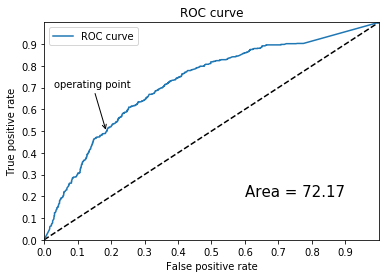

In [185]:
idx_op = (np.abs(thresholds_roc - decision_thr)).argmin()

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='ROC curve')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xticks(np.arange(0, 1, step=0.1))
plt.yticks(np.arange(0, 1, step=0.1))

plt.text(0.6, 0.2, "Area = {}".format(round(AUROC,2)), dict(size=15))

plt.annotate("operating point", xy=(fpr[idx_op],tpr[idx_op]), xytext=(0.03,0.7), arrowprops=dict(arrowstyle='->'))

plt.legend(loc='best')
plt.show()

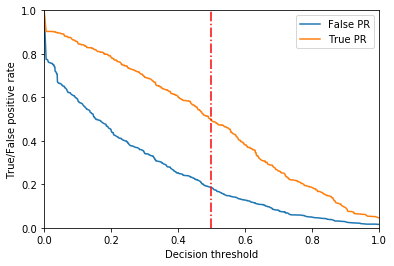

In [150]:
plt.figure(2)
plt.plot(thresholds_roc, fpr , label='False PR')
plt.plot(thresholds_roc, tpr, label='True PR')

plt.axvline(x=decision_thr, color='r', linestyle='-.')

plt.xlabel('Decision threshold')
plt.ylabel('True/False positive rate')
#plt.title('ROC curve')

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.legend(loc='best')
plt.show()

In [33]:
precision_vec, recall_vec, thresholds_pr = precision_recall_curve(y_true, y_prob)

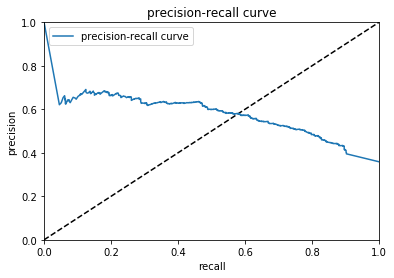

In [34]:
plt.figure(3)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(recall_vec, precision_vec, label='precision-recall curve')

plt.xlabel('recall')
plt.ylabel('precision')
plt.title('precision-recall curve')

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.legend(loc='best')
plt.show()

# Metrics among protected classes

## Deployed model

In [35]:
df_obs_classes = pd.DataFrame({df_obs_known.SubjectRaceCode.name: df_obs_known.SubjectRaceCode, 
                                df_obs_known.SubjectEthnicityCode.name: df_obs_known.SubjectEthnicityCode, 
                                df_obs_known.SubjectSexCode.name: df_obs_known.SubjectSexCode, 
                                'y_true': y_true, 
                                'y_pred': y_pred})

In [36]:
#sanity check
df_obs_classes.shape[0] == df_obs_known.shape[0]

True

In [37]:
obs_race_results = df_obs_classes.groupby(['SubjectRaceCode','y_true', 'y_pred']).SubjectRaceCode.count()
obs_ethnic_results = df_obs_classes.groupby(['SubjectEthnicityCode','y_true', 'y_pred']).SubjectEthnicityCode.count()
obs_sex_results = df_obs_classes.groupby(['SubjectSexCode','y_true', 'y_pred']).SubjectSexCode.count()

Sanity checks:

In [38]:
obs_race_results[:,1,:].sum() == obs_ethnic_results[:,1,:].sum() == obs_sex_results[:,1,:].sum() == y_true.sum()

True

In [39]:
obs_race_results[:,:,1].sum() == obs_ethnic_results[:,:,1].sum() == obs_sex_results[:,:,1].sum() == y_pred.sum()

True

In [40]:
df_obs_classes.head(10)

,SubjectRaceCode,SubjectEthnicityCode,SubjectSexCode,y_true,y_pred
id,,,,,
0,B,N,M,0,0
1,B,N,M,0,0
2,B,N,F,1,0
3,B,N,F,1,0
4,W,N,M,0,0
5,W,N,M,0,0
6,W,H,M,0,0
7,W,H,M,0,0
8,B,N,F,0,1


### Precision overall

In [41]:
precision_score(y_true, y_pred)

0.6005416384563304

In [42]:
# Sanity check
df_obs_classes[df_obs_classes.y_pred==1].y_true.mean()

0.6005416384563304

### Precision among races

Precision table:

In [43]:
df_obs_classes[df_obs_classes.y_pred==1].groupby('SubjectRaceCode').y_true.mean().apply(lambda x: x*100)

SubjectRaceCode
A    57.142857
B    59.292035
I    50.000000
W    60.476663
Name: y_true, dtype: float64

Max. difference:

In [44]:
(df_obs_classes[df_obs_classes.y_pred==1].groupby('SubjectRaceCode').y_true.mean().max() - df_obs_classes[df_obs_classes.y_pred==1].groupby('SubjectRaceCode').y_true.mean().min())*100

10.476663356504467

Max. difference [%]:

In [45]:
(1 - df_obs_classes[df_obs_classes.y_pred==1].groupby('SubjectRaceCode').y_true.mean().min() / df_obs_classes[df_obs_classes.y_pred==1].groupby('SubjectRaceCode').y_true.mean().max())*100

17.32348111658456

Standard difference:

In [46]:
df_obs_classes[df_obs_classes.y_pred==1].groupby('SubjectRaceCode').y_true.mean().apply(lambda x: x*100).std()

4.692719356742923

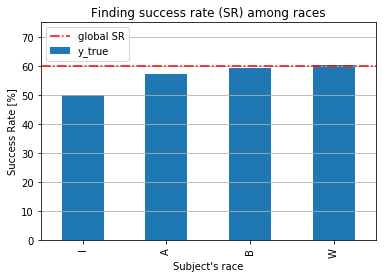

In [47]:
(df_obs_classes[df_obs_classes.y_pred==1].groupby('SubjectRaceCode')
                                              .y_true.mean().apply(lambda x: x*100).sort_values()
                                              .to_frame().plot.bar(label=''))

plt.axhline(y=precision*100, color='r', linestyle='-.', label='global SR')

plt.title('Finding success rate (SR) among races')
plt.xlabel("Subject's race")
plt.ylabel("Success Rate [%]")

plt.ylim(0,75)

plt.legend(loc='upper left')
plt.grid(axis='y')

#plt.savefig(os.path.join('plots', 'discrimination_race_SR.png'));

### Precision among ethnicities

When the classifier predicts positive, it is more sure about the prediction for Whites than for Blacks.

Precision table:

In [48]:
df_obs_classes[df_obs_classes.y_pred==1].groupby('SubjectEthnicityCode').y_true.mean().apply(lambda x: x*100)

SubjectEthnicityCode
H    55.747126
N    61.381754
Name: y_true, dtype: float64

Max. difference:

In [49]:
(df_obs_classes[df_obs_classes.y_pred==1].groupby('SubjectEthnicityCode').y_true.mean().max() - df_obs_classes[df_obs_classes.y_pred==1].groupby('SubjectEthnicityCode').y_true.mean().min())*100

5.634627327611652

Max. difference [%]:

In [50]:
(1 - df_obs_classes[df_obs_classes.y_pred==1].groupby('SubjectEthnicityCode').y_true.mean().min() / df_obs_classes[df_obs_classes.y_pred==1].groupby('SubjectEthnicityCode').y_true.mean().max())*100

9.179645386541925

Standard difference:

In [51]:
df_obs_classes[df_obs_classes.y_pred==1].groupby('SubjectEthnicityCode').y_true.mean().apply(lambda x: x*100).std()

3.9842831928132347

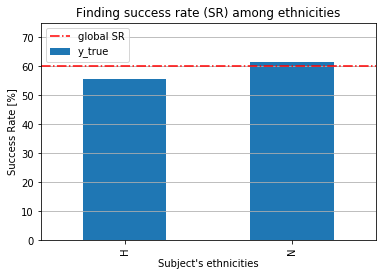

In [52]:
(df_obs_classes[df_obs_classes.y_pred==1].groupby('SubjectEthnicityCode')
                                              .y_true.mean().apply(lambda x: x*100).sort_values()
                                              .to_frame().plot.bar(label=''))

plt.axhline(y=precision*100, color='r', linestyle='-.', label='global SR')

plt.title('Finding success rate (SR) among ethnicities')
plt.xlabel("Subject's ethnicities")
plt.ylabel("Success Rate [%]")

plt.ylim(0,75)

plt.legend(loc='upper left')
plt.grid(axis='y')

#plt.savefig(os.path.join('plots', 'discrimination_race_SR.png'));

### Precision among sexes

Precision table:

In [53]:
df_obs_classes[df_obs_classes.y_pred==1].groupby('SubjectSexCode').y_true.mean().apply(lambda x: x*100)

SubjectSexCode
F    58.199357
M    60.548885
Name: y_true, dtype: float64

Max. difference [p.p.]:

In [54]:
(df_obs_classes[df_obs_classes.y_pred==1].groupby('SubjectSexCode').y_true.mean().max() - df_obs_classes[df_obs_classes.y_pred==1].groupby('SubjectSexCode').y_true.mean().min())*100

2.349528164003689

Max. difference [%]:

In [55]:
(1 - df_obs_classes[df_obs_classes.y_pred==1].groupby('SubjectSexCode').y_true.mean().min() / df_obs_classes[df_obs_classes.y_pred==1].groupby('SubjectSexCode').y_true.mean().max())*100

3.8803822085386686

Standard difference:

In [56]:
df_obs_classes[df_obs_classes.y_pred==1].groupby('SubjectSexCode').y_true.mean().apply(lambda x: x*100).std()

1.6613672973557905

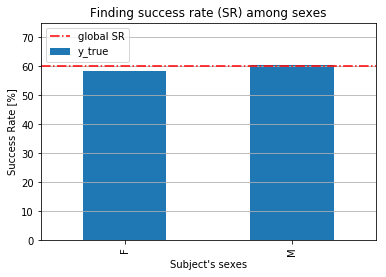

In [57]:
(df_obs_classes[df_obs_classes.y_pred==1].groupby('SubjectSexCode')
                                              .y_true.mean().apply(lambda x: x*100).sort_values()
                                              .to_frame().plot.bar(label=''))

plt.axhline(y=precision*100, color='r', linestyle='-.', label='global SR')

plt.title('Finding success rate (SR) among sexes')
plt.xlabel("Subject's sexes")
plt.ylabel("Success Rate [%]")

plt.ylim(0,75)

plt.legend(loc='upper left')
plt.grid(axis='y')

#plt.savefig(os.path.join('plots', 'discrimination_race_SR.png'));

---

---

---

---

## All requests (previous method; without model decision)

### Precision overall

In [58]:
y_true.mean()

0.359

In [59]:
precision2

0.359

### Precision among races

Precision table:

In [60]:
df_obs_classes.groupby('SubjectRaceCode').y_true.mean().apply(lambda x: x*100)

SubjectRaceCode
A    26.086957
B    34.512725
I    20.000000
W    36.753675
Name: y_true, dtype: float64

Max. difference:

In [61]:
(df_obs_classes.groupby('SubjectRaceCode').y_true.mean().max() - df_obs_classes.groupby('SubjectRaceCode').y_true.mean().min())*100

16.75367536753675

Max. difference [%]:

In [62]:
(1 - df_obs_classes.groupby('SubjectRaceCode').y_true.mean().min() / df_obs_classes.groupby('SubjectRaceCode').y_true.mean().max())*100

45.583673469387755

Standard difference:

In [63]:
df_obs_classes.groupby('SubjectRaceCode').y_true.mean().apply(lambda x: x*100).std()

7.736009897015541

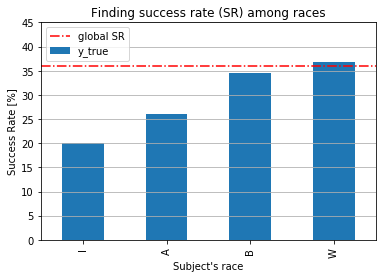

In [64]:
(df_obs_classes.groupby('SubjectRaceCode')
                                              .y_true.mean().apply(lambda x: x*100).sort_values()
                                              .to_frame().plot.bar(label=''))

plt.axhline(y=precision2*100, color='r', linestyle='-.', label='global SR')

plt.title('Finding success rate (SR) among races')
plt.xlabel("Subject's race")
plt.ylabel("Success Rate [%]")

plt.ylim(0,45)

plt.legend(loc='upper left')
plt.grid(axis='y')

#plt.savefig(os.path.join('plots', 'discrimination_race_SR.png'));

### Precision among ethnicities

When the classifier predicts positive, it is more sure about the prediction for Whites than for Blacks.

Precision table:

In [65]:
df_obs_classes.groupby('SubjectEthnicityCode').y_true.mean().apply(lambda x: x*100)

SubjectEthnicityCode
H    29.843750
N    37.983871
Name: y_true, dtype: float64

Max. difference:

In [66]:
(df_obs_classes.groupby('SubjectEthnicityCode').y_true.mean().max() - df_obs_classes.groupby('SubjectEthnicityCode').y_true.mean().min())*100

8.140120967741932

Max. difference [%]:

In [67]:
(1 - df_obs_classes.groupby('SubjectEthnicityCode').y_true.mean().min() / df_obs_classes.groupby('SubjectEthnicityCode').y_true.mean().max())*100

21.430467091295103

Standard difference:

In [68]:
df_obs_classes.groupby('SubjectEthnicityCode').y_true.mean().apply(lambda x: x*100).std()

5.755934735969122

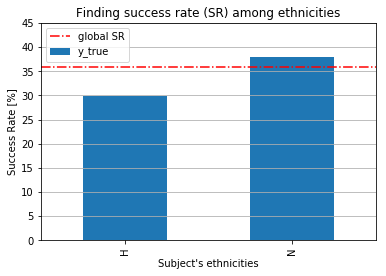

In [69]:
(df_obs_classes.groupby('SubjectEthnicityCode')
                                              .y_true.mean().apply(lambda x: x*100).sort_values()
                                              .to_frame().plot.bar(label=''))

plt.axhline(y=precision2*100, color='r', linestyle='-.', label='global SR')

plt.title('Finding success rate (SR) among ethnicities')
plt.xlabel("Subject's ethnicities")
plt.ylabel("Success Rate [%]")

plt.ylim(0,45)

plt.legend(loc='upper left')
plt.grid(axis='y')

#plt.savefig(os.path.join('plots', 'discrimination_race_SR.png'));

### Precision among sexes

Precision table:

In [70]:
df_obs_classes.groupby('SubjectSexCode').y_true.mean().apply(lambda x: x*100)

SubjectSexCode
F    31.866029
M    36.965866
Name: y_true, dtype: float64

Max. difference [p.p.]:

In [71]:
(df_obs_classes.groupby('SubjectSexCode').y_true.mean().max() - df_obs_classes.groupby('SubjectSexCode').y_true.mean().min())*100

5.099837284280695

Max. difference [%]:

In [72]:
(1 - df_obs_classes.groupby('SubjectSexCode').y_true.mean().min() / df_obs_classes.groupby('SubjectSexCode').y_true.mean().max())*100

13.796071449610226

Standard difference:

In [73]:
df_obs_classes.groupby('SubjectSexCode').y_true.mean().apply(lambda x: x*100).std()

3.606129526662864

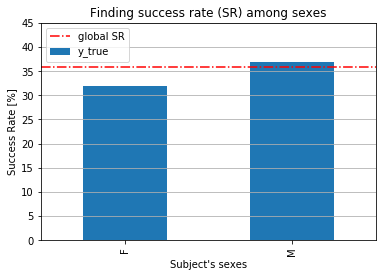

In [74]:
(df_obs_classes.groupby('SubjectSexCode')
                                              .y_true.mean().apply(lambda x: x*100).sort_values()
                                              .to_frame().plot.bar(label=''))

plt.axhline(y=precision2*100, color='r', linestyle='-.', label='global SR')

plt.title('Finding success rate (SR) among sexes')
plt.xlabel("Subject's sexes")
plt.ylabel("Success Rate [%]")

plt.ylim(0,45)

plt.legend(loc='upper left')
plt.grid(axis='y')

#plt.savefig(os.path.join('plots', 'discrimination_race_SR.png'));

---

---

---

# Population analysis

### 'SubjectRaceCode': 'race'

In [75]:
s_obs_race = df_obs.groupby('SubjectRaceCode').SubjectRaceCode.count().sort_values()
s_obs_race = s_obs_race.div(s_obs_race.sum())*100
s_obs_race

SubjectRaceCode
I     0.339932
A     0.699860
B    33.613277
W    65.346931
Name: SubjectRaceCode, dtype: float64

In [76]:
# sanity check
assert s_obs_race.sum() == 100

In [77]:
s_train_race = df_train.groupby('SubjectRaceCode').SubjectRaceCode.count().sort_values()
s_train_race = s_train_race.div(s_train_race.sum())*100
s_train_race

SubjectRaceCode
I     0.286671
A     0.648919
B    29.319938
W    69.744472
Name: SubjectRaceCode, dtype: float64

In [78]:
# sanity check
assert s_train_race.sum() == 100

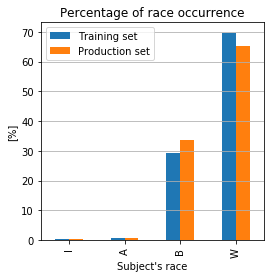

In [231]:
pd.DataFrame({'Training set': s_train_race, 'Production set': s_obs_race}).sort_values(by='Training set').plot.bar(figsize=(4,4))

plt.title('Percentage of race occurrence')
plt.xlabel("Subject's race")
plt.ylabel("[%]")

#plt.yticks(np.arange(0, 70, step=5))

plt.grid(axis='y')

#plt.legend(['Training set', 'Production set'])

plt.savefig(os.path.join('plots', 'report2_population_race_compare.png'));

### 'SubjectEthnicityCode': 'ethnic'

In [80]:
s_obs_ethnic = df_obs.groupby('SubjectEthnicityCode').SubjectEthnicityCode.count().sort_values()
s_obs_ethnic = s_obs_ethnic.div(s_obs_ethnic.sum())*100
s_obs_ethnic

SubjectEthnicityCode
H    26.074785
N    73.925215
Name: SubjectEthnicityCode, dtype: float64

In [81]:
# sanity check
assert s_obs_ethnic.sum() == 100

In [82]:
s_train_ethnic = df_train.groupby('SubjectEthnicityCode').SubjectEthnicityCode.count().sort_values()
s_train_ethnic = s_train_ethnic.div(s_train_ethnic.sum())*100
s_train_ethnic

SubjectEthnicityCode
M     1.141472
H    22.834656
N    76.023872
Name: SubjectEthnicityCode, dtype: float64

In [83]:
# sanity check
assert s_train_ethnic.sum() == 100

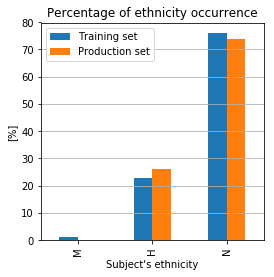

In [232]:
pd.DataFrame({'Training set': s_train_ethnic, 'Production set': s_obs_ethnic}).sort_values(by='Training set').plot.bar(figsize=(4,4))

plt.title('Percentage of ethnicity occurrence')
plt.xlabel("Subject's ethnicity")
plt.ylabel("[%]")

plt.grid(axis='y')

#plt.legend(['Training set', 'Production set'])

plt.savefig(os.path.join('plots', 'report2_population_ethnic_compare.png'));

### 'SubjectSexCode': 'sex'

In [85]:
s_obs_sex = df_obs.groupby('SubjectSexCode').SubjectSexCode.count().sort_values()
s_obs_sex = s_obs_sex.div(s_obs_sex.sum())*100
s_obs_sex

SubjectSexCode
F    20.135973
M    79.864027
Name: SubjectSexCode, dtype: float64

In [86]:
# sanity check
assert s_obs_sex.sum() == 100

In [87]:
s_train_sex = df_train.groupby('SubjectSexCode').SubjectSexCode.count().sort_values()
s_train_sex = s_train_sex.div(s_train_sex.sum())*100
s_train_sex

SubjectSexCode
F    18.31698
M    81.68302
Name: SubjectSexCode, dtype: float64

In [88]:
# sanity check
assert s_train_sex.sum() == 100

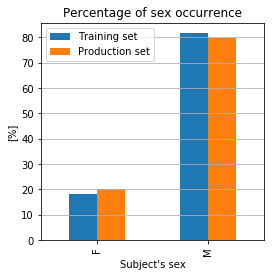

In [233]:
pd.DataFrame({'Training set': s_train_sex, 'Production set': s_obs_sex}).sort_values(by='Training set').plot.bar(figsize=(4,4))

plt.title('Percentage of sex occurrence')
plt.xlabel("Subject's sex")
plt.ylabel("[%]")

plt.grid(axis='y')

#plt.legend(['Training set', 'Production set'])

plt.savefig(os.path.join('plots', 'report2_population_sex_compare.png'));

### 'SearchAuthorizationCode': 'search_reason'

In [199]:
s_obs_search_reason = df_obs.groupby('SearchAuthorizationCode').SearchAuthorizationCode.count().sort_values()
s_obs_search_reason = s_obs_search_reason.div(s_obs_search_reason.sum())*100
s_obs_search_reason

SearchAuthorizationCode
N     2.439512
I    24.935013
C    30.383923
O    42.241552
Name: SearchAuthorizationCode, dtype: float64

In [200]:
# sanity check
assert s_obs_search_reason.sum() == 100

In [201]:
s_train_search_reason = df_train.groupby('SearchAuthorizationCode').SearchAuthorizationCode.count().sort_values()
s_train_search_reason = s_train_search_reason.div(s_train_search_reason.sum())*100
s_train_search_reason

SearchAuthorizationCode
N     4.287595
I    20.473590
C    35.269050
O    39.969765
Name: SearchAuthorizationCode, dtype: float64

In [202]:
# sanity check
assert s_train_search_reason.sum() == 100

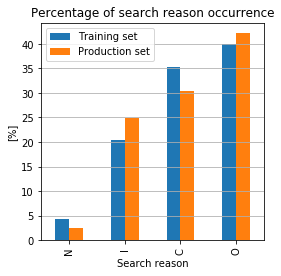

In [234]:
pd.DataFrame({'Training set': s_train_search_reason, 'Production set': s_obs_search_reason}).sort_values(by='Training set').plot.bar(figsize=(4,4))

plt.title('Percentage of search reason occurrence')
plt.xlabel("Search reason")
plt.ylabel("[%]")

plt.grid(axis='y')

#plt.legend(['Training set', 'Production set'])

plt.savefig(os.path.join('plots', 'report2_population_search_reason_compare.png'));

### 'StatuteReason': 'stop_reason'

In [204]:
s_obs_stop_reason  = df_obs.groupby('StatuteReason').StatuteReason.count().sort_values()
s_obs_stop_reason  = s_obs_stop_reason .div(s_obs_stop_reason .sum())*100
s_obs_stop_reason 

StatuteReason
Equipment Violation        0.499900
STC Violation              0.939812
Unlicensed Operation       1.339732
Cell Phone                 2.339532
Seatbelt                   3.319336
Traffic Control Signal     4.239152
Stop Sign                  4.779044
Window Tint                5.148970
Defective Lights           9.478104
Display of Plates         10.257948
Registration              10.257948
Speed Related             10.657868
Administrative Offense    11.497700
Other                     12.007598
Moving Violation          13.237353
Name: StatuteReason, dtype: float64

In [205]:
# sanity check
assert s_obs_stop_reason .sum() == 100

In [206]:
s_train_stop_reason  = df_train.groupby('StatuteReason').StatuteReason.count().sort_values()
s_train_stop_reason  = s_train_stop_reason .div(s_train_stop_reason .sum())*100
s_train_stop_reason 

StatuteReason
Stop Sign                  0.003910
Equipment Violation        0.732410
STC Violation              0.775416
Unlicensed Operation       0.908345
Suspended License          1.793231
Cell Phone                 2.255874
Seatbelt                   2.831898
Other/Error                2.919213
Window Tint                4.398368
Traffic Control Signal     4.842766
Stop Sign                  4.871437
Administrative Offense     6.314102
Display of Plates          7.635567
Registration               9.551301
Speed Related             10.858431
Defective Lights          11.894491
Moving Violation          12.991803
Other                     14.421435
Name: StatuteReason, dtype: float64

In [207]:
# sanity check
assert s_train_stop_reason .sum() == 100

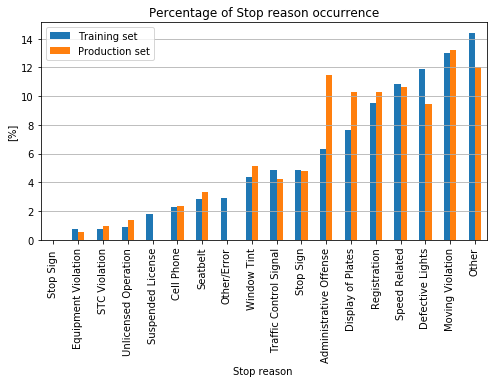

In [235]:
pd.DataFrame({'Training set': s_train_stop_reason , 'Production set': s_obs_stop_reason }).sort_values(by='Training set').plot.bar(figsize=(8,4))

plt.title('Percentage of Stop reason occurrence')
plt.xlabel("Stop reason ")
plt.ylabel("[%]")

plt.grid(axis='y')

#plt.legend(['Training set', 'Production set'])

plt.savefig(os.path.join('plots', 'report2_population_stop_reason_compare.png'));

### 'SubjectAge': 'age'

In [214]:
s_obs_age = df_obs.groupby('SubjectAge').SubjectAge.count().sort_values()
s_obs_age = s_obs_age .div(s_obs_age .sum())*100

In [215]:
# sanity check
assert s_obs_age.sum() == 100

In [217]:
s_train_age = df_train.groupby('SubjectAge').SubjectAge.count().sort_values()
s_train_age = s_train_age .div(s_train_age .sum())*100

In [219]:
# sanity check
assert s_train_age.sum() == 100

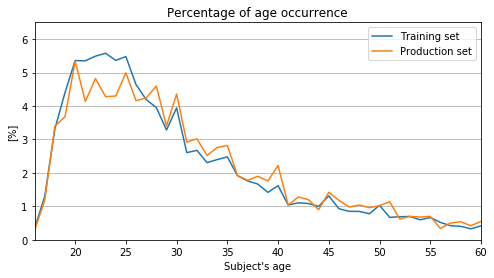

In [236]:
pd.DataFrame({'Training set': s_train_age, 'Production set': s_obs_age}).sort_index().plot.line(figsize=(8,4))

plt.title("Percentage of age occurrence")
plt.xlabel("Subject's age")
plt.ylabel("[%]")

plt.xlim(16,60)
plt.ylim(0,6.5)

plt.grid(axis='y')

#plt.legend(['Training set', 'Production set'])

#plt.savefig(os.path.join('plots', 'report2_population_age _compare.png'));

---

---

---

# Model dynamic evaluation

Load results on the test set from previously saved data (see `classifier_workflow` notebook).

In [194]:
file_path = os.path.join('data', 'test_set_performance.csv')

try:
    df_test_set_performance = pd.read_csv(file_path, 
                             header=0,
                             warn_bad_lines=True)
except:
    print('Ooops!!! We got an error!')
else:
    pass    

Results on the test set:

In [195]:
y_prob_test = df_test_set_performance.y_prob
y_pred_test = df_test_set_performance.y_pred
y_true_test = df_test_set_performance.y_true

In [196]:
fpr_test, tpr_test, thresholds_roc_test = roc_curve(y_true_test, y_prob_test)
AUROC_test = roc_auc_score(y_true_test, y_prob_test)*100

Plot again ROC curve and True/False positives curves, now including results on the test set.

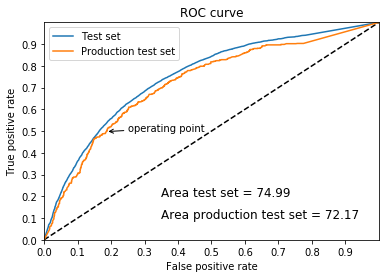

In [197]:
plt.figure(3)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_test, tpr_test, label='Test set')
plt.plot(fpr, tpr, label='Production test set')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xticks(np.arange(0, 1, step=0.1))
plt.yticks(np.arange(0, 1, step=0.1))


plt.text(0.35, 0.1, "Area production test set = {}".format(round(AUROC,2)), dict(size=12))
plt.text(0.35, 0.2, "Area test set = {}".format(round(AUROC_test,2)), dict(size=12))

plt.annotate("operating point", xy=(fpr[idx_op],tpr[idx_op]), xytext=(0.25,0.5), arrowprops=dict(arrowstyle='->'))

plt.legend(loc='best')

plt.savefig(os.path.join('plots', 'report2_ROC_curves_compare.png'));
#plt.show()

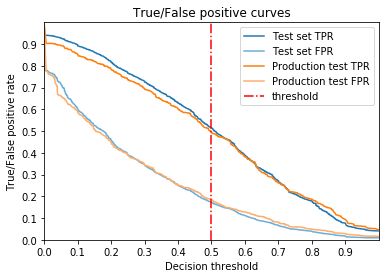

In [198]:
plt.figure(4)

plt.plot(thresholds_roc_test, tpr_test, label='Test set TPR', color='C0')
plt.plot(thresholds_roc_test, fpr_test , label='Test set FPR', color='#6baed6')

plt.plot(thresholds_roc, tpr, label='Production test TPR', color='C1')
plt.plot(thresholds_roc, fpr , label='Production test FPR', color='#fdae6b')

plt.axvline(x=decision_thr, color='r', linestyle='-.', label='threshold')

plt.xlabel('Decision threshold')
plt.ylabel('True/False positive rate')
plt.title('True/False positive curves')

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xticks(np.arange(0, 1, step=0.1))
plt.yticks(np.arange(0, 1, step=0.1))

plt.legend(loc='best')
plt.savefig(os.path.join('plots', 'report2_TF_positives_curves_compare.png'));